In [33]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt 
import datetime
import pandas as pd

#database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas

In [34]:
# load the database
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

print('snowexsql database successfully loaded!')

snowexsql database successfully loaded!


In [35]:
def parse_veg_class(site_id):
    
    '''
    This function parses snow pit data into three vegetation classes:
        - 1). Treeless, 2). Sparce, and 3). Dense
        
    It uses a python dictionary where:
        (k) keys: are the vegetation classes
        (v) values: are the first digit in the pitID assignment

    
    '''
    
    # Classifying by vegetation coverage 
    veg_class = {'treeless':[1, 2, 3], 'sparse':[4, 5, 6], 'dense':[7, 8, 9]}
     
    vclass = None 
    
    class_id = site_id[0]
    
    if class_id.isnumeric():
        class_id = int(class_id)

        for k,v in veg_class.items():

            if class_id in v: #if the first digit in the site_id is 'v' assign it to the corresponding 'k'
                vclass = k 
                
    return vclass 

In [36]:
def parse_depth_class(site_id):
    
    '''
    This function parses snow pit data into three depth classes:
        - 1). Shallow, 2). Medium, and 3). Deep
        
    It uses a python dictionary where:
        (k) keys: are the depth classes
        (v) values: are the first digit in the pitID assignment
      
  
    '''
        
    # Classifying by 2017 depth 
    depth_class = {'shallow':[1, 4, 7], 'medium':[2, 5, 8], 'deep':[3, 6, 9]} 
   
    dclass = None 
    
    class_id = site_id[0]
    
    if class_id.isnumeric(): #for the outlier TS site
        class_id = int(class_id) #cast as integer

        for k,v in depth_class.items(): #for the key, value pairs in the dict listed above:

            if class_id in v: #if the first digit in the site_id is 'v' assign it to the corresponding 'k'
                dclass = k 

    return dclass 

In [37]:
# Load the database
db_name = 'snow:hackweek@52.32.183.144/snowex'
engine, session = get_db(db_name)

# Query for Layer Data
#result = session.query(LayerData.type).distinct().all()

# Filter for density data
qry = session.query(LayerData).filter(LayerData.type=='temperature')

# Form our dataframe from the query 
df = query_to_geopandas(qry, engine)
df['value'] = df['value'].astype(float)  #cast the value as a float (they are strings)

# Parse snow pit data by the veg/depth matrix
df['veg_class'] = [parse_veg_class(i) for i in df['site_id']] #run the parse_veg function for every site_id
df['depth_class'] = [parse_depth_class(i) for i in df['site_id']] #run the parse_depth funciton for every site_id

# Select columns of interest
col_list = ['site_id', 'date', 'type', 'latitude',
       'longitude', 'depth', 'value', 'veg_class', 'depth_class']
df = df[col_list]

# View a sample --> notice parsed veg_class and depth_class columns were added!
df.head(10)

OperationalError: (psycopg2.OperationalError) FATAL:  remaining connection slots are reserved for non-replication superuser connections

(Background on this error at: http://sqlalche.me/e/13/e3q8)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1675 entries, 0 to 1674
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1675 non-null   object 
 1   date         1675 non-null   object 
 2   type         1675 non-null   object 
 3   latitude     1675 non-null   float64
 4   longitude    1675 non-null   float64
 5   depth        1675 non-null   float64
 6   value        1672 non-null   float64
 7   veg_class    1628 non-null   object 
 8   depth_class  1628 non-null   object 
dtypes: float64(4), object(5)
memory usage: 117.9+ KB


In [16]:
df.index = pd.to_datetime(df['date'])

<AxesSubplot:xlabel='date'>

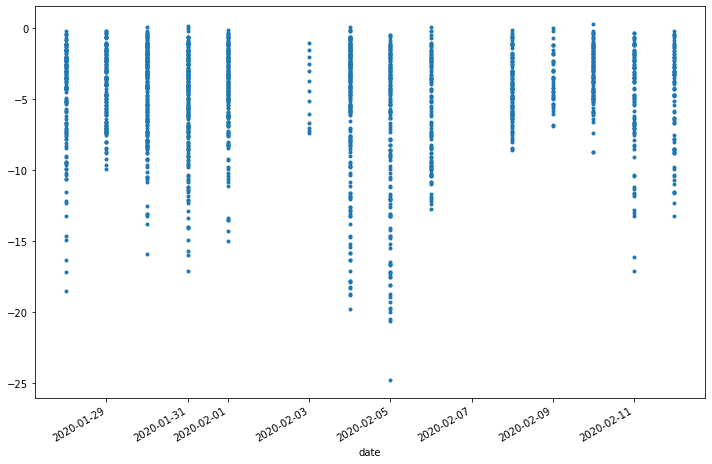

In [31]:
df['value'].plot(figsize=(12,8), style=".")

<AxesSubplot:xlabel='date'>

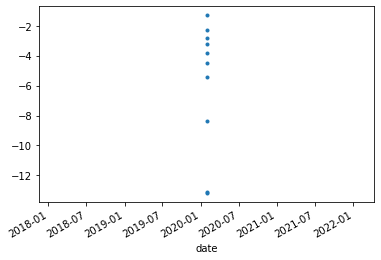

In [32]:
df['value'].loc[df['site_id']=='5C21'].plot(style=".")